In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [2]:
# Load the three CSV files
df_filtered = pd.read_csv('pandas/df_filtered.csv')
agg_df = pd.read_csv('pandas/agg_df.csv')
fish_df = pd.read_csv('pandas/fish_df.csv')

# <a id='toc2_'></a>[Agglomerative  Cluster Analysis](#toc0_)
## <a id='toc2_1_'></a>[Outliers](#toc0_)
Before we perform the agglomerative clustering, we removed assemblages that are considered substantial outliers. To define these outliers, we computed the pairwise distances between assemblages, and found the median distance to each other assemblage, per-assemblage. This was done for both the cosine and SPAM metrics defined earlier. The resulting distributions are provided below. 


To stay consistent with previous ecological analyses we will only use the Jaccard distance metric for clustering.

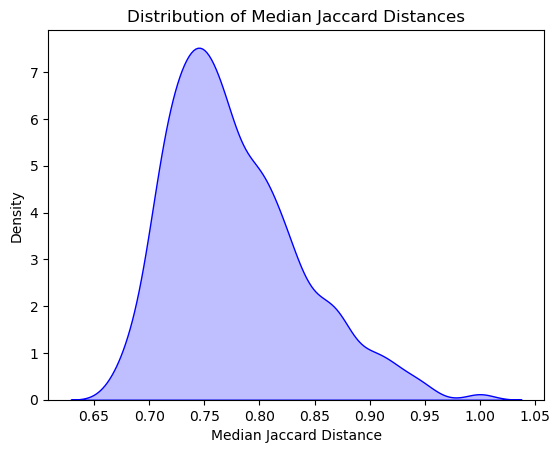

In [3]:
dist_matrix_jac = pdist(1*fish_df, metric='jaccard') 
dist_df_jac = pd.DataFrame(squareform(dist_matrix_jac))

sns.kdeplot(dist_df_jac.median(axis=0), fill=True, color="blue")
plt.xlabel("Median Jaccard Distance")
plt.ylabel("Density")
plt.title("Distribution of Median Jaccard Distances")
plt.show()

Possible outlier, but will not remove any data points.

In [4]:
fish_df.head()

,LKSG,BDDR,SNSG,BRBT,CLDR,BNBH,STCT,BKCP,BNMW,SGER,...,LNGR,HHCB,BSMW,SJHR,GDRH,UNID,BNDR,FHCF,MDDR,PDSN
0,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False


In [5]:
from joblib import Parallel, delayed
import fastcluster  # faster C++ linkage implementation (same API shape)
from sklearn.metrics import adjusted_rand_score

thresholds = np.arange(0.74, 0.90, 0.01)
n_bootstrap = 1000
sample_frac = 0.90
n_samples = len(fish_df)
sample_size = int(n_samples * sample_frac)

# Precompute full linkage and labels for every threshold once
full_dist = pdist(fish_df.values.astype(int), metric='jaccard')
# use fastcluster.linkage if available for speed
full_linkage = fastcluster.linkage(full_dist, method='average')  # returns condensed linkage
full_labels_by_threshold = {t: fcluster(full_linkage, t=t, criterion='distance') for t in thresholds}

def one_bootstrap(seed):
    rng = np.random.default_rng(seed)
    idx = rng.choice(n_samples, size=sample_size, replace=False)
    sub_data = fish_df.iloc[idx].values.astype(int)
    sub_dist = pdist(sub_data, metric='jaccard')
    sub_linkage = fastcluster.linkage(sub_dist, method='average')
    # compute ARI for each threshold comparing sub_labels to full_labels restricted to idx
    ari_list = []
    num_clusters = []
    cluster_size_cvs = []
    for t in thresholds:
        sub_labels = fcluster(sub_linkage, t=t, criterion='distance')
        # compare to full labels computed earlier for the same t
        full_labels = full_labels_by_threshold[t][idx]
        ari_list.append(adjusted_rand_score(full_labels, sub_labels))
        num_clusters.append(len(np.unique(sub_labels)))
        cs = pd.Series(sub_labels).value_counts()
        cluster_size_cvs.append(cs.std() / cs.mean())
    return {'ari': np.array(ari_list), 'num_clusters': np.array(num_clusters), 'cluster_size_cvs': np.array(cluster_size_cvs)}

# Run bootstraps in parallel (adjust n_jobs to CPU cores)
results = Parallel(n_jobs=8, backend='loky')(delayed(one_bootstrap)(seed) for seed in range(n_bootstrap))

# Aggregate per-threshold results
aris = np.vstack([r['ari'] for r in results])            # shape (n_bootstrap, n_thresholds)
num_clusters = np.vstack([r['num_clusters'] for r in results])
cluster_cvs = np.vstack([r['cluster_size_cvs'] for r in results])

mean_ari = aris.mean(axis=0)
std_ari = aris.std(axis=0)
cv_ari = std_ari / mean_ari
mean_num_clusters = num_clusters.mean(axis=0)
std_num_clusters = num_clusters.std(axis=0)
mean_cluster_size_cv = cluster_cvs.mean(axis=0)
# Compile results into DataFrame
stability_results = []
for i, threshold in enumerate(thresholds):
    # Get full dataset clustering (already computed in full_labels_by_threshold)
    labels = full_labels_by_threshold[threshold]
    cluster_sizes = pd.Series(labels).value_counts()
    
    stability_results.append({
        'threshold': threshold,
        'num_clusters': len(cluster_sizes),
        'num_large_clusters': (cluster_sizes >= 10).sum(),
        'mean_ari': mean_ari[i],
        'std_ari': std_ari[i],
        'cv_ari': cv_ari[i] if mean_ari[i] > 0 else np.inf,
        'mean_num_clusters': mean_num_clusters[i],
        'std_num_clusters': std_num_clusters[i],
        'mean_cluster_size_cv': mean_cluster_size_cv[i]
    })

stability_df = pd.DataFrame(stability_results)
# -----------------------------------------------

RESULTS: Most Stable Thresholds

1. HIGHEST STABILITY (Mean ARI):
   Threshold: 0.840
   Mean ARI: 0.7024 ± 0.1149
   Number of clusters: 17
   Large clusters (≥10): 4

2. MOST CONSISTENT (Lowest CV of ARI):
   Threshold: 0.760
   CV of ARI: 0.0773
   Mean ARI: 0.6141 ± 0.0475
   Number of clusters: 44

3. BEST OVERALL BALANCE:
   Threshold: 0.830
   Mean ARI: 0.7010 ± 0.0849
   CV of ARI: 0.1212
   Number of clusters: 18
   Large clusters (≥10): 4


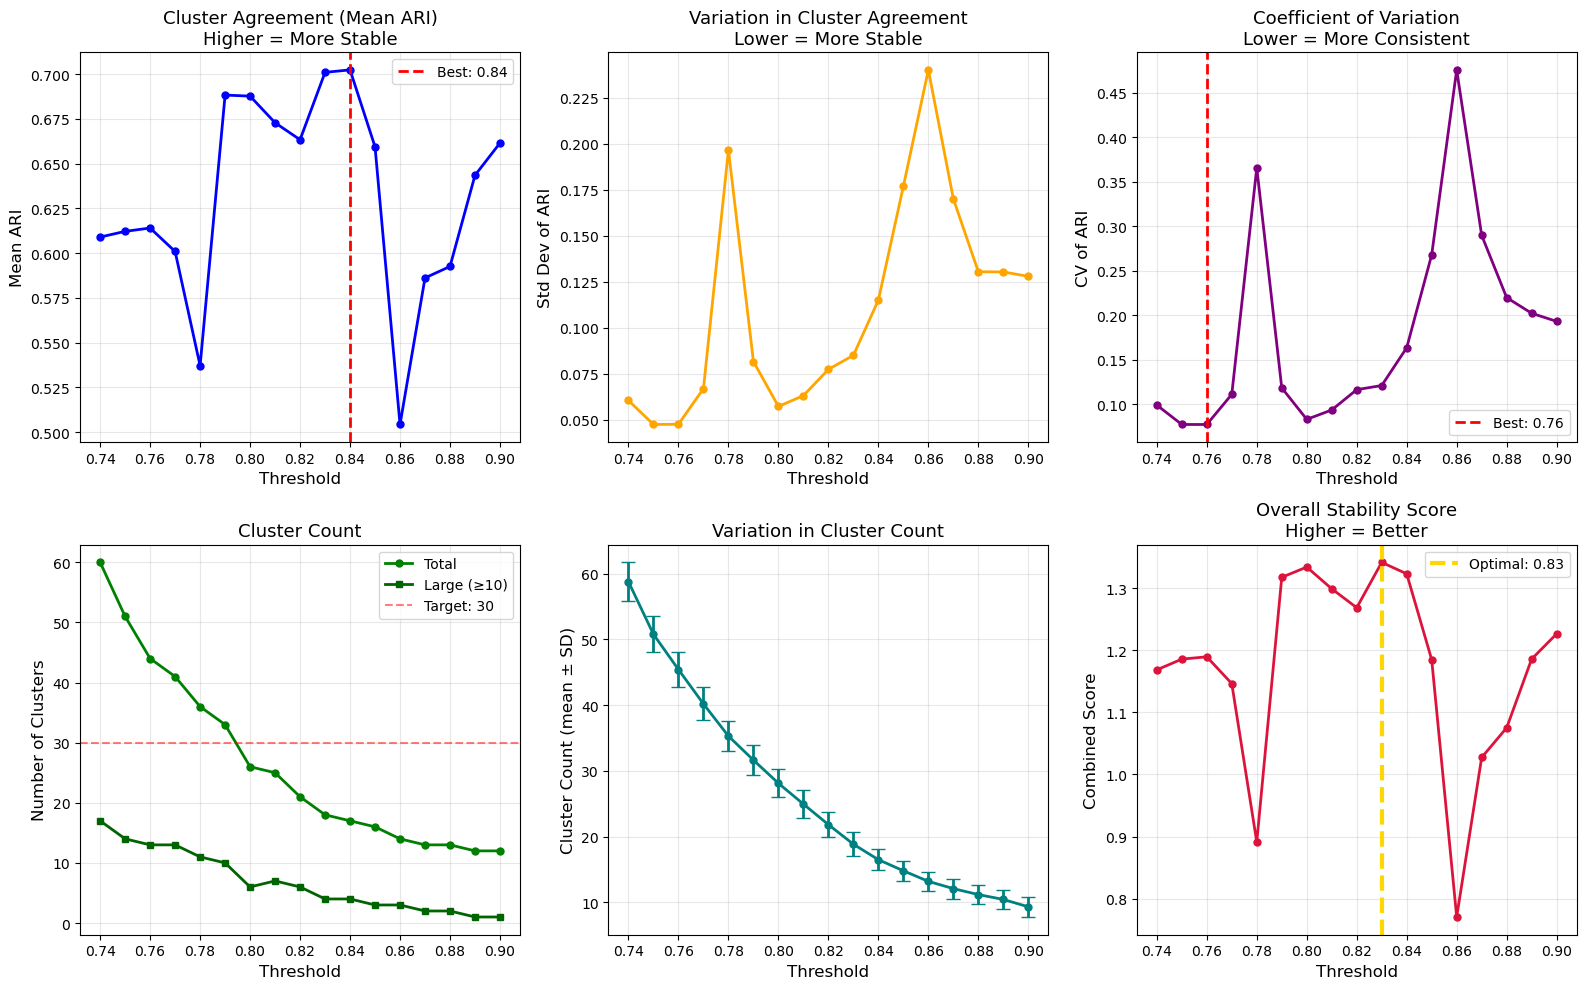

🎯 RECOMMENDATION:
   Use threshold = 0.840 for maximum stability
   This produces 4 large clusters with
   Mean ARI = 0.7024 (closer to 1.0 = more stable)


In [6]:

# Find optimal thresholds
print("=" * 80)
print("RESULTS: Most Stable Thresholds")
print("=" * 80)

# 1. Highest mean ARI (best agreement with full clustering)
best_ari = stability_df.loc[stability_df['mean_ari'].idxmax()]
print(f"\n1. HIGHEST STABILITY (Mean ARI):")
print(f"   Threshold: {best_ari['threshold']:.3f}")
print(f"   Mean ARI: {best_ari['mean_ari']:.4f} ± {best_ari['std_ari']:.4f}")
print(f"   Number of clusters: {best_ari['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_ari['num_large_clusters']:.0f}")

# 2. Lowest coefficient of variation in ARI (most consistent)
best_cv = stability_df.loc[stability_df['cv_ari'].idxmin()]
print(f"\n2. MOST CONSISTENT (Lowest CV of ARI):")
print(f"   Threshold: {best_cv['threshold']:.3f}")
print(f"   CV of ARI: {best_cv['cv_ari']:.4f}")
print(f"   Mean ARI: {best_cv['mean_ari']:.4f} ± {best_cv['std_ari']:.4f}")
print(f"   Number of clusters: {best_cv['num_clusters']:.0f}")

# 3. Best balance (high ARI + low CV + reasonable cluster count)
stability_df['combined_score'] = (
    stability_df['mean_ari'] * 2 -  # Maximize agreement
    stability_df['cv_ari'] * 0.5 
    # -  # Minimize variation
    # abs(stability_df['num_large_clusters'] - 15) * 0.1  # Prefer ~15 large clusters
)

best_combined = stability_df.loc[stability_df['combined_score'].idxmax()]
print(f"\n3. BEST OVERALL BALANCE:")
print(f"   Threshold: {best_combined['threshold']:.3f}")
print(f"   Mean ARI: {best_combined['mean_ari']:.4f} ± {best_combined['std_ari']:.4f}")
print(f"   CV of ARI: {best_combined['cv_ari']:.4f}")
print(f"   Number of clusters: {best_combined['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_combined['num_large_clusters']:.0f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Mean ARI (higher is better)
axes[0, 0].plot(stability_df['threshold'], stability_df['mean_ari'], 
                'b-o', markersize=5, linewidth=2)
axes[0, 0].axvline(best_ari['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_ari['threshold']:.2f}")
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Mean ARI', fontsize=12)
axes[0, 0].set_title('Cluster Agreement (Mean ARI)\nHigher = More Stable', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Std Dev of ARI (lower is better)
axes[0, 1].plot(stability_df['threshold'], stability_df['std_ari'], 
                'orange', marker='o', markersize=5, linewidth=2)
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('Std Dev of ARI', fontsize=12)
axes[0, 1].set_title('Variation in Cluster Agreement\nLower = More Stable', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coefficient of Variation (lower is better)
axes[0, 2].plot(stability_df['threshold'], stability_df['cv_ari'], 
                'purple', marker='o', markersize=5, linewidth=2)
axes[0, 2].axvline(best_cv['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_cv['threshold']:.2f}")
axes[0, 2].set_xlabel('Threshold', fontsize=12)
axes[0, 2].set_ylabel('CV of ARI', fontsize=12)
axes[0, 2].set_title('Coefficient of Variation\nLower = More Consistent', fontsize=13)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Number of clusters
axes[1, 0].plot(stability_df['threshold'], stability_df['num_clusters'], 
                'g-o', markersize=5, linewidth=2, label='Total')
axes[1, 0].plot(stability_df['threshold'], stability_df['num_large_clusters'], 
                'darkgreen', marker='s', markersize=5, linewidth=2, label='Large (≥10)')
axes[1, 0].axhline(30, color='red', linestyle='--', alpha=0.5, label='Target: 30')
axes[1, 0].set_xlabel('Threshold', fontsize=12)
axes[1, 0].set_ylabel('Number of Clusters', fontsize=12)
axes[1, 0].set_title('Cluster Count', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Stability of cluster count
axes[1, 1].errorbar(stability_df['threshold'], stability_df['mean_num_clusters'],
                    yerr=stability_df['std_num_clusters'], fmt='o-', 
                    capsize=5, markersize=5, linewidth=2, color='teal')
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('Cluster Count (mean ± SD)', fontsize=12)
axes[1, 1].set_title('Variation in Cluster Count', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Combined score
axes[1, 2].plot(stability_df['threshold'], stability_df['combined_score'], 
                'crimson', marker='o', markersize=5, linewidth=2)
axes[1, 2].axvline(best_combined['threshold'], color='gold', linestyle='--', 
                   linewidth=3, label=f"Optimal: {best_combined['threshold']:.2f}")
axes[1, 2].set_xlabel('Threshold', fontsize=12)
axes[1, 2].set_ylabel('Combined Score', fontsize=12)
axes[1, 2].set_title('Overall Stability Score\nHigher = Better', fontsize=13)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 RECOMMENDATION:")
print(f"   Use threshold = {best_ari['threshold']:.3f} for maximum stability")
print(f"   This produces {best_ari['num_large_clusters']:.0f} large clusters with")
print(f"   Mean ARI = {best_ari['mean_ari']:.4f} (closer to 1.0 = more stable)")

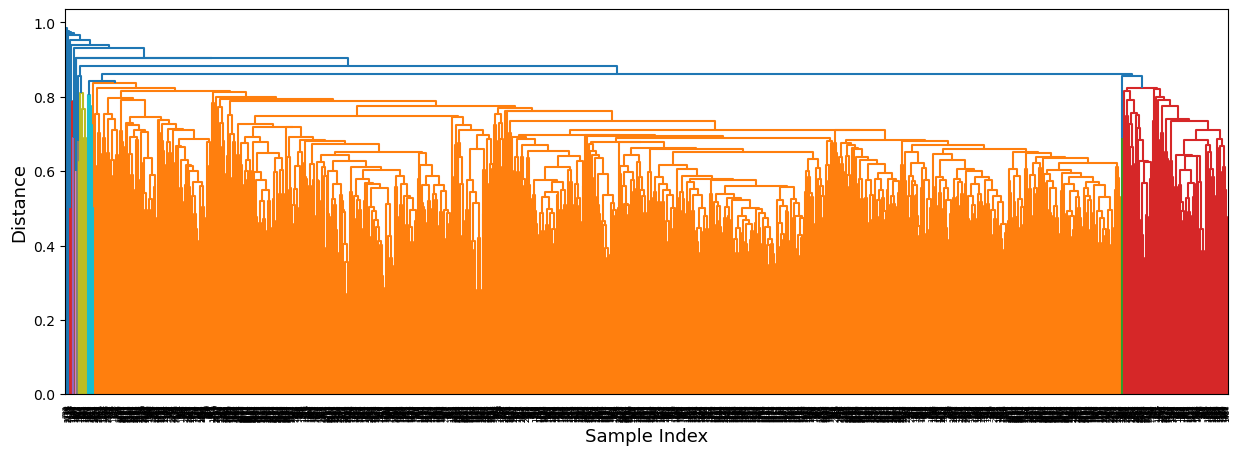


=== CLUSTER SUMMARY (threshold=0.84) ===
Total clusters: 17
Clusters with >10 samples: 4
Clusters with >50 samples: 2

Cluster sizes:
cluster
1     2135
2      217
3       19
4       10
5        5
6        5
7        4
9        3
8        3
10       2
11       2
12       2
13       1
14       1
15       1
16       1
17       1
dtype: int64


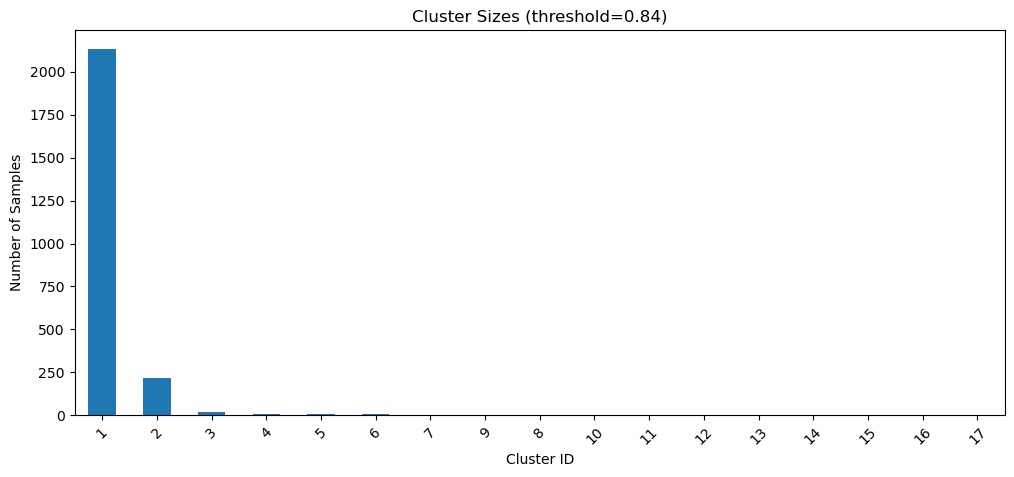

In [7]:
from scipy.cluster.hierarchy import dendrogram 

linked_jaccard = linkage(dist_matrix_jac, method='average')

cluster_threshold = 0.84
plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard, color_threshold=cluster_threshold) # you can change this value to change the number of clusters you get
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)
plt.show()

# First assign clusters using fcluster
agg_df['cluster'] = fcluster(linked_jaccard, t=cluster_threshold, criterion='distance')
fish_df['cluster'] = agg_df['cluster']

# Then reassign cluster numbers in order by cluster size (largest = 1)
cluster_sizes = agg_df['cluster'].value_counts().sort_values(ascending=False)
cluster_map = {old: new for new, old in enumerate(cluster_sizes.index, 1)}
agg_df['cluster'] = agg_df['cluster'].map(cluster_map)
fish_df['cluster'] = agg_df['cluster']

# Summary of clusters
cluster_summary = agg_df.groupby('cluster').size().sort_values(ascending=False)
print(f"\n=== CLUSTER SUMMARY (threshold={cluster_threshold}) ===")
print(f"Total clusters: {len(cluster_summary)}")
print(f"Clusters with >10 samples: {(cluster_summary >= 10).sum()}")
print(f"Clusters with >50 samples: {(cluster_summary >= 50).sum()}")
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title(f'Cluster Sizes (threshold={cluster_threshold})')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

In [8]:
agg_df.to_csv('pandas/agg_df_cluster.csv', index=False)
fish_df.to_csv('pandas/fish_df_cluster.csv', index=False)

Cluster within Largest Cluster

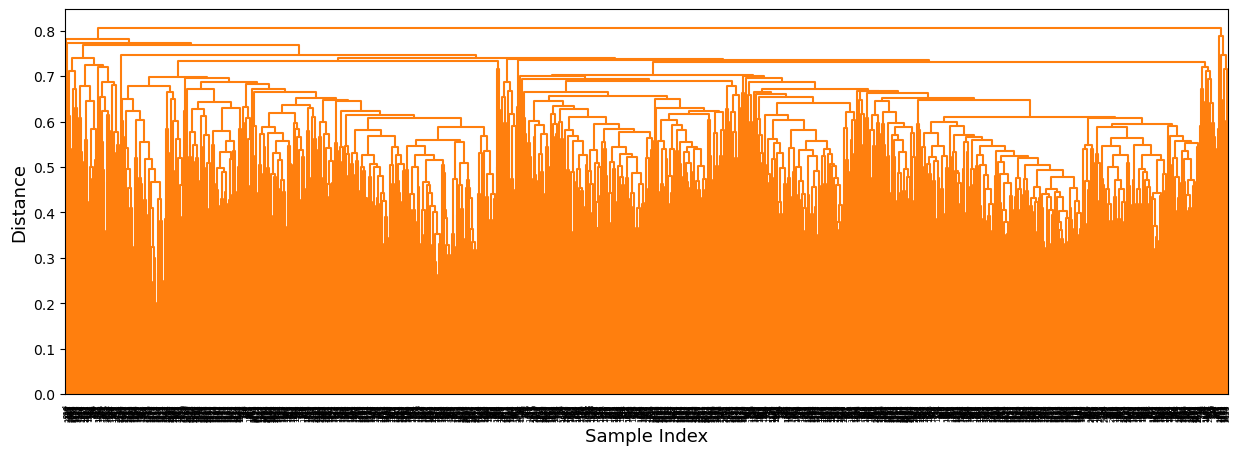

In [11]:
fish_df_large_cluster = fish_df[fish_df['cluster'] == 1]

dist_matrix_jac_large_cluster = pdist(1*fish_df_large_cluster, metric='jaccard') 
dist_df_jac_large_cluster  = pd.DataFrame(squareform(dist_matrix_jac_large_cluster ))

linked_jaccard_large_cluster = linkage(dist_matrix_jac_large_cluster, method='average')

cluster_threshold = 0.84
plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard_large_cluster, color_threshold=cluster_threshold) # you can change this value to change the number of clusters you get
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)
plt.show()


In [14]:
from joblib import Parallel, delayed
import fastcluster  # faster C++ linkage implementation (same API shape)
from sklearn.metrics import adjusted_rand_score

thresholds = np.arange(0.68, 0.75, 0.01)
n_bootstrap = 1000
sample_frac = 0.90
n_samples = len(fish_df_large_cluster)
sample_size = int(n_samples * sample_frac)

# Precompute full linkage and labels for every threshold once
# In largest cluster
full_dist = pdist(fish_df_large_cluster.values.astype(int), metric='jaccard')
# use fastcluster.linkage if available for speed
full_linkage = fastcluster.linkage(full_dist, method='average')  # returns condensed linkage
full_labels_by_threshold = {t: fcluster(full_linkage, t=t, criterion='distance') for t in thresholds}

def one_bootstrap(seed):
    rng = np.random.default_rng(seed)
    idx = rng.choice(n_samples, size=sample_size, replace=False)
    sub_data = fish_df_large_cluster.iloc[idx].values.astype(int)
    sub_dist = pdist(sub_data, metric='jaccard')
    sub_linkage = fastcluster.linkage(sub_dist, method='average')
    # compute ARI for each threshold comparing sub_labels to full_labels restricted to idx
    ari_list = []
    num_clusters = []
    cluster_size_cvs = []
    for t in thresholds:
        sub_labels = fcluster(sub_linkage, t=t, criterion='distance')
        # compare to full labels computed earlier for the same t
        full_labels = full_labels_by_threshold[t][idx]
        ari_list.append(adjusted_rand_score(full_labels, sub_labels))
        num_clusters.append(len(np.unique(sub_labels)))
        cs = pd.Series(sub_labels).value_counts()
        cluster_size_cvs.append(cs.std() / cs.mean())
    return {'ari': np.array(ari_list), 'num_clusters': np.array(num_clusters), 'cluster_size_cvs': np.array(cluster_size_cvs)}

# Run bootstraps in parallel (adjust n_jobs to CPU cores)
results = Parallel(n_jobs=8, backend='loky')(delayed(one_bootstrap)(seed) for seed in range(n_bootstrap))

# Aggregate per-threshold results
aris = np.vstack([r['ari'] for r in results])            # shape (n_bootstrap, n_thresholds)
num_clusters = np.vstack([r['num_clusters'] for r in results])
cluster_cvs = np.vstack([r['cluster_size_cvs'] for r in results])

mean_ari = aris.mean(axis=0)
std_ari = aris.std(axis=0)
cv_ari = std_ari / mean_ari
mean_num_clusters = num_clusters.mean(axis=0)
std_num_clusters = num_clusters.std(axis=0)
mean_cluster_size_cv = cluster_cvs.mean(axis=0)
# Compile results into DataFrame
stability_results = []
for i, threshold in enumerate(thresholds):
    # Get full dataset clustering (already computed in full_labels_by_threshold)
    labels = full_labels_by_threshold[threshold]
    cluster_sizes = pd.Series(labels).value_counts()
    
    stability_results.append({
        'threshold': threshold,
        'num_clusters': len(cluster_sizes),
        'num_large_clusters': (cluster_sizes >= 10).sum(),
        'mean_ari': mean_ari[i],
        'std_ari': std_ari[i],
        'cv_ari': cv_ari[i] if mean_ari[i] > 0 else np.inf,
        'mean_num_clusters': mean_num_clusters[i],
        'std_num_clusters': std_num_clusters[i],
        'mean_cluster_size_cv': mean_cluster_size_cv[i]
    })

stability_df = pd.DataFrame(stability_results)
# -----------------------------------------------

RESULTS: Most Stable Thresholds

1. HIGHEST STABILITY (Mean ARI):
   Threshold: 0.720
   Mean ARI: 0.6017 ± 0.0695
   Number of clusters: 17
   Large clusters (≥10): 7

2. MOST CONSISTENT (Lowest CV of ARI):
   Threshold: 0.720
   CV of ARI: 0.1155
   Mean ARI: 0.6017 ± 0.0695
   Number of clusters: 17

3. BEST OVERALL BALANCE:
   Threshold: 0.720
   Mean ARI: 0.6017 ± 0.0695
   CV of ARI: 0.1155
   Number of clusters: 17
   Large clusters (≥10): 7


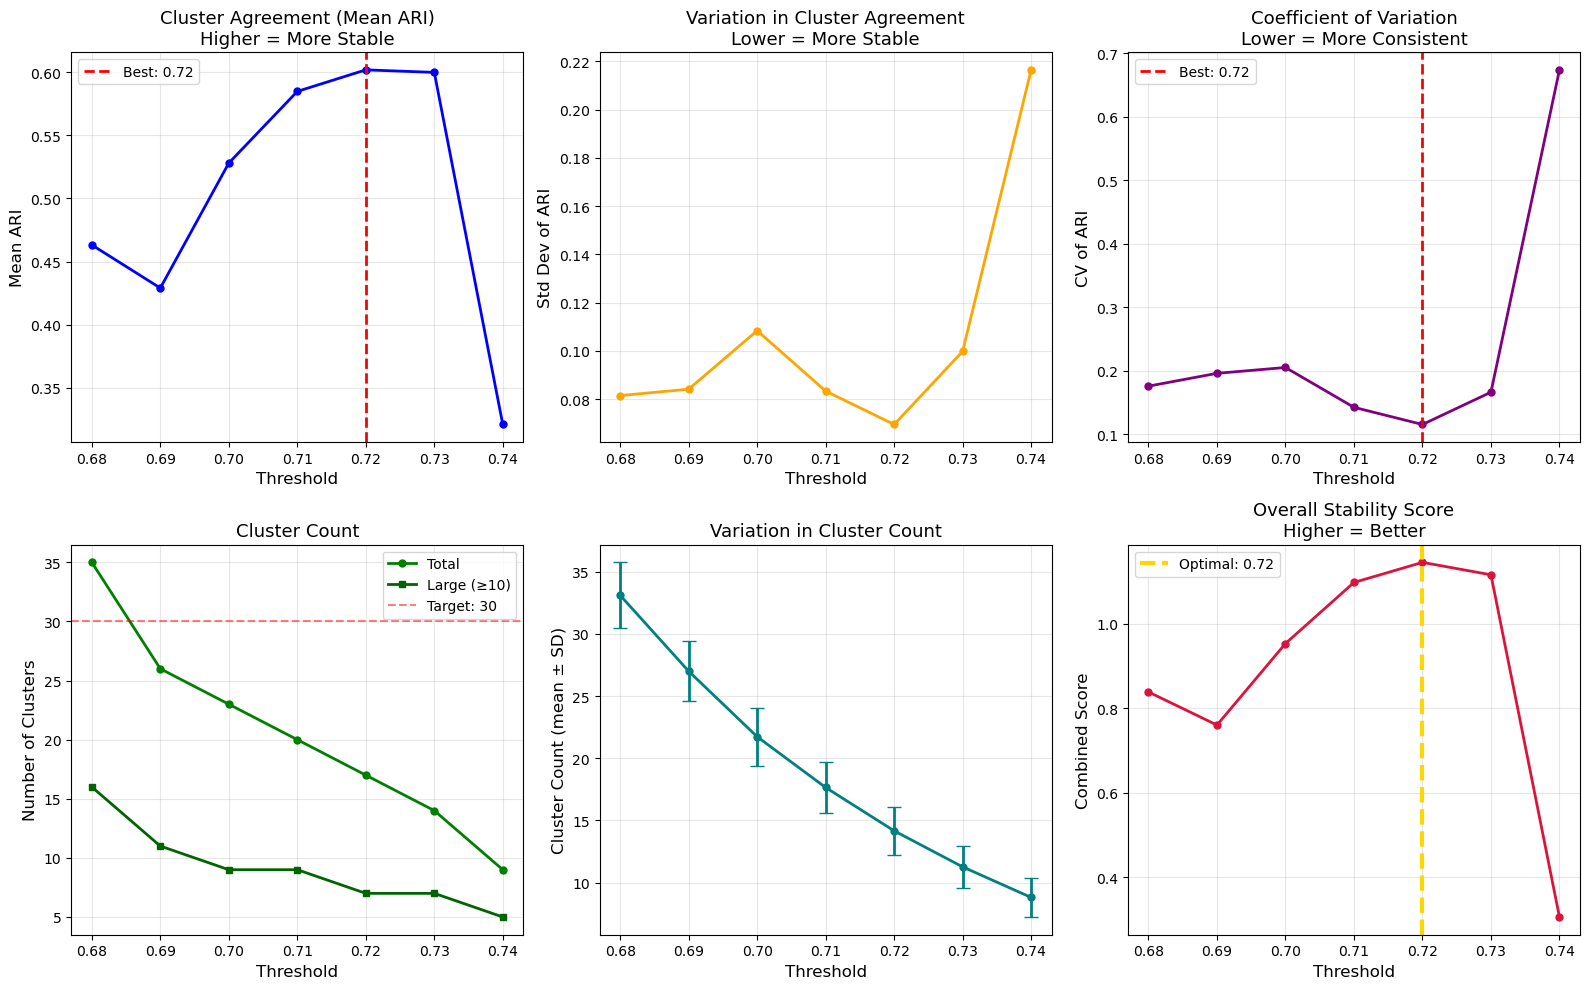

🎯 RECOMMENDATION:
   Use threshold = 0.720 for maximum stability
   This produces 7 large clusters with
   Mean ARI = 0.6017 (closer to 1.0 = more stable)


In [ ]:
# Find optimal thresholds
print("=" * 80)
print("RESULTS: Most Stable Thresholds")
print("=" * 80)

# 1. Highest mean ARI (best agreement with full clustering)
best_ari = stability_df.loc[stability_df['mean_ari'].idxmax()]
print(f"\n1. HIGHEST STABILITY (Mean ARI):")
print(f"   Threshold: {best_ari['threshold']:.3f}")
print(f"   Mean ARI: {best_ari['mean_ari']:.4f} ± {best_ari['std_ari']:.4f}")
print(f"   Number of clusters: {best_ari['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_ari['num_large_clusters']:.0f}")

# 2. Lowest coefficient of variation in ARI (most consistent)
best_cv = stability_df.loc[stability_df['cv_ari'].idxmin()]
print(f"\n2. MOST CONSISTENT (Lowest CV of ARI):")
print(f"   Threshold: {best_cv['threshold']:.3f}")
print(f"   CV of ARI: {best_cv['cv_ari']:.4f}")
print(f"   Mean ARI: {best_cv['mean_ari']:.4f} ± {best_cv['std_ari']:.4f}")
print(f"   Number of clusters: {best_cv['num_clusters']:.0f}")

# 3. Best balance (high ARI + low CV + reasonable cluster count)
stability_df['combined_score'] = (
    stability_df['mean_ari'] * 2 -  # Maximize agreement
    stability_df['cv_ari'] * 0.5 
    # -  # Minimize variation
    # abs(stability_df['num_large_clusters'] - 15) * 0.1  # Prefer ~15 large clusters
)

best_combined = stability_df.loc[stability_df['combined_score'].idxmax()]
print(f"\n3. BEST OVERALL BALANCE:")
print(f"   Threshold: {best_combined['threshold']:.3f}")
print(f"   Mean ARI: {best_combined['mean_ari']:.4f} ± {best_combined['std_ari']:.4f}")
print(f"   CV of ARI: {best_combined['cv_ari']:.4f}")
print(f"   Number of clusters: {best_combined['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_combined['num_large_clusters']:.0f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Mean ARI (higher is better)
axes[0, 0].plot(stability_df['threshold'], stability_df['mean_ari'], 
                'b-o', markersize=5, linewidth=2)
axes[0, 0].axvline(best_ari['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_ari['threshold']:.2f}")
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Mean ARI', fontsize=12)
axes[0, 0].set_title('Cluster Agreement (Mean ARI)\nHigher = More Stable', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Std Dev of ARI (lower is better)
axes[0, 1].plot(stability_df['threshold'], stability_df['std_ari'], 
                'orange', marker='o', markersize=5, linewidth=2)
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('Std Dev of ARI', fontsize=12)
axes[0, 1].set_title('Variation in Cluster Agreement\nLower = More Stable', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coefficient of Variation (lower is better)
axes[0, 2].plot(stability_df['threshold'], stability_df['cv_ari'], 
                'purple', marker='o', markersize=5, linewidth=2)
axes[0, 2].axvline(best_cv['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_cv['threshold']:.2f}")
axes[0, 2].set_xlabel('Threshold', fontsize=12)
axes[0, 2].set_ylabel('CV of ARI', fontsize=12)
axes[0, 2].set_title('Coefficient of Variation\nLower = More Consistent', fontsize=13)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Number of clusters
axes[1, 0].plot(stability_df['threshold'], stability_df['num_clusters'], 
                'g-o', markersize=5, linewidth=2, label='Total')
axes[1, 0].plot(stability_df['threshold'], stability_df['num_large_clusters'], 
                'darkgreen', marker='s', markersize=5, linewidth=2, label='Large (≥10)')
axes[1, 0].axhline(30, color='red', linestyle='--', alpha=0.5, label='Target: 30')
axes[1, 0].set_xlabel('Threshold', fontsize=12)
axes[1, 0].set_ylabel('Number of Clusters', fontsize=12)
axes[1, 0].set_title('Cluster Count', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Stability of cluster count
axes[1, 1].errorbar(stability_df['threshold'], stability_df['mean_num_clusters'],
                    yerr=stability_df['std_num_clusters'], fmt='o-', 
                    capsize=5, markersize=5, linewidth=2, color='teal')
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('Cluster Count (mean ± SD)', fontsize=12)
axes[1, 1].set_title('Variation in Cluster Count', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Combined score
axes[1, 2].plot(stability_df['threshold'], stability_df['combined_score'], 
                'crimson', marker='o', markersize=5, linewidth=2)
axes[1, 2].axvline(best_combined['threshold'], color='gold', linestyle='--', 
                   linewidth=3, label=f"Optimal: {best_combined['threshold']:.2f}")
axes[1, 2].set_xlabel('Threshold', fontsize=12)
axes[1, 2].set_ylabel('Combined Score', fontsize=12)
axes[1, 2].set_title('Overall Stability Score\nHigher = Better', fontsize=13)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 RECOMMENDATION:")
print(f"   Use threshold = {best_ari['threshold']:.3f} for maximum stability")
print(f"   This produces {best_ari['num_large_clusters']:.0f} large clusters with")
print(f"   Mean ARI = {best_ari['mean_ari']:.4f} (closer to 1.0 = more stable)")

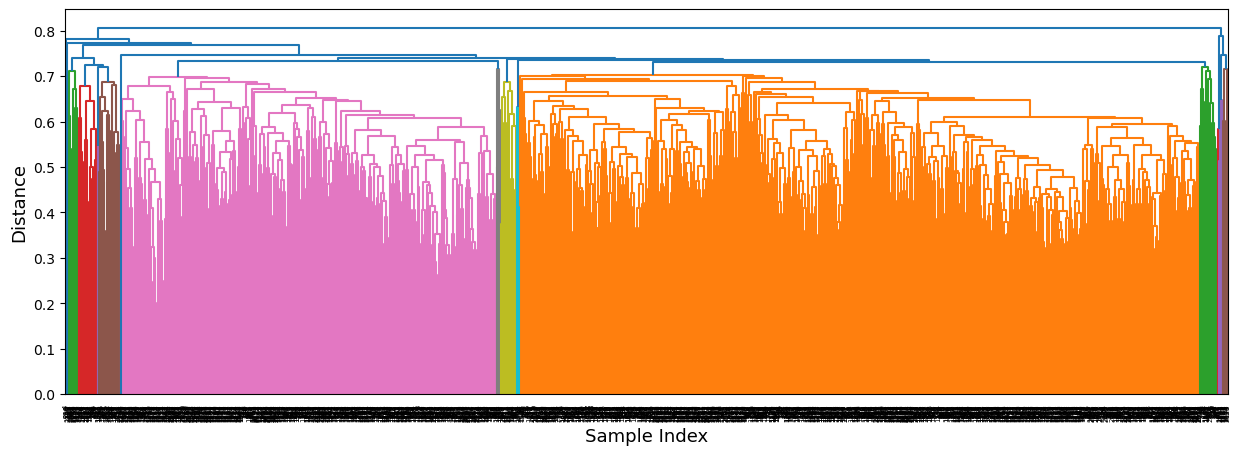


=== CLUSTER SUMMARY (threshold=0.72) ===
Total clusters: 16
Clusters with >10 samples: 8
Clusters with >50 samples: 2

Cluster sizes:
cluster
1     1251
2      690
3       40
4       35
5       33
6       29
7       20
8       10
9        8
10       6
11       4
12       3
13       2
14       2
15       1
16       1
dtype: int64


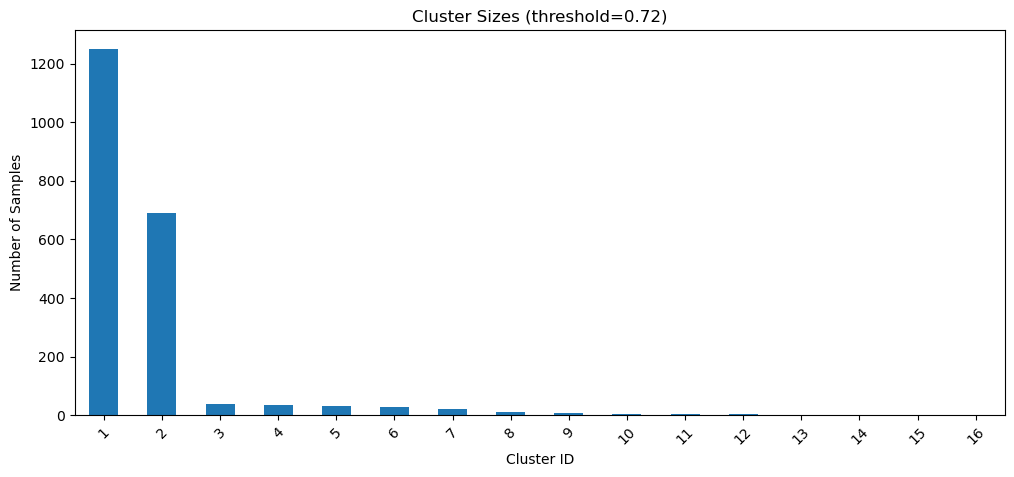

In [16]:
from scipy.cluster.hierarchy import dendrogram 

linked_jaccard_large_cluster = linkage(dist_matrix_jac_large_cluster, method='average')

cluster_threshold = 0.72
plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard_large_cluster, color_threshold=cluster_threshold) # you can change this value to change the number of clusters you get
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)
plt.show()

agg_df_large_cluster = agg_df[agg_df['cluster'] == 1].copy()
fish_df_large_cluster = fish_df[fish_df['cluster'] == 1].copy()


# First assign clusters using fcluster
agg_df_large_cluster['cluster'] = fcluster(linked_jaccard_large_cluster, 
                             t=cluster_threshold, criterion='distance')
fish_df_large_cluster['cluster'] = agg_df_large_cluster['cluster']

# Then reassign cluster numbers in order by cluster size (largest = 1)
cluster_sizes = agg_df_large_cluster['cluster'].value_counts().sort_values(ascending=False)
cluster_map = {old: new for new, old in enumerate(cluster_sizes.index, 1)}
agg_df_large_cluster['cluster'] = agg_df_large_cluster['cluster'].map(cluster_map)
fish_df_large_cluster['cluster'] = agg_df_large_cluster['cluster']

# Summary of clusters
cluster_summary = agg_df_large_cluster.groupby('cluster').size().sort_values(ascending=False)
print(f"\n=== CLUSTER SUMMARY (threshold={cluster_threshold}) ===")
print(f"Total clusters: {len(cluster_summary)}")
print(f"Clusters with >10 samples: {(cluster_summary >= 10).sum()}")
print(f"Clusters with >50 samples: {(cluster_summary >= 50).sum()}")
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title(f'Cluster Sizes (threshold={cluster_threshold})')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

In [17]:
agg_df_large_cluster.to_csv('pandas/agg_df_large_cluster.csv', index=False)
fish_df_large_cluster.to_csv('pandas/fish_df_large_cluster.csv', index=False)